In [1]:
# !pip uninstall fsspec -y
# !pip install --upgrade fsspec
# !pip install transformers accelerate datasets

train note
<br>https://www.kaggle.com/takeshikobayashi/meanpooling-roberta-base-representation-technique

# Define

In [2]:

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from accelerate import Accelerator
from transformers import (AutoModel,AutoConfig,
                          AutoTokenizer,get_cosine_schedule_with_warmup)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL


# import os
# import math
# import random
# import time

# import numpy as np
# import pandas as pd

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

# from transformers import AdamW
# from transformers import AutoTokenizer
# from transformers import AutoModel
# from transformers import AutoConfig
# from transformers import get_cosine_schedule_with_warmup

# from sklearn.model_selection import KFold

# import gc
# gc.enable()

In [3]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

train_data['excerpt'] = train_data['excerpt'].apply(lambda x: x.replace('\n',''))


##イランデータdrop
train_data.drop(train_data[(train_data.target == 0) & (train_data.standard_error == 0)].index,
              inplace=True)
train_data.reset_index(drop=True, inplace=True)


num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42,
    'model_path':'../input/clrp-roberta-base/clrp_roberta_base',
}

for i in range(config['nfolds']):
    os.makedirs(f'model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [4]:
train_data

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,0
...,...,...,...,...,...,...,...,...
2828,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11,3
2829,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,8,2
2830,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,8,4
2831,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,7,1


In [5]:
# class CLRPDataset(Dataset):
#     def __init__(self,df,tokenizer,max_len=128):
#         self.excerpt = df['excerpt'].to_numpy()
#         self.targets = df['target'].to_numpy()
#         self.max_len = max_len
#         self.tokenizer = tokenizer
    
#     def __getitem__(self,idx):
#         encode = self.tokenizer(self.excerpt[idx],
#                                 return_tensors='pt',
#                                 max_length=self.max_len,
#                                 padding='max_length',
#                                 truncation=True)
        
#         target = torch.tensor(self.targets[idx],dtype=torch.float)
#         return encode, target
    
#     def __len__(self):
#         return len(self.excerpt)
    
    

class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.excerpt = df['excerpt'].to_numpy()
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],return_tensors='pt',
                                max_length=config['max_len'],
                                padding='max_length',truncation=True)
        return encode
    
    def __len__(self):
        return len(self.excerpt)
    
    
    
### mean pooling 
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        self.config = AutoConfig.from_pretrained(path)
        self.config.update({'output_hidden_states':True,"hidden_dropout_prob": 0.0})
        self.roberta = AutoModel.from_pretrained(path,config=self.config)  
#         self.linear = nn.Linear(self.config.hidden_size*4, 1, 1)
        self.linear = nn.Linear(self.config.hidden_size, 1)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)

    def forward(self,**xb):
        attention_mask = xb['attention_mask']
        outputs = self.roberta(**xb)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        norm_mean_embeddings = self.layer_norm(mean_embeddings)
        logits = self.linear(norm_mean_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        return preds.view(-1).float()

# stacking

In [6]:
pred = []
pred0 = []
pred1 = []
pred2 = []
pred3 = []
pred4 = []

FOLDS = 5
EPOCHS = 3
BATCH = 8
MAX_LEN = 248
# TOKENIZER_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"

# all_predictions = np.zeros((5, len(x_val)))

# tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

for fold in range(FOLDS):

    x_train = train_data.loc[train_data.Fold != fold, 'excerpt'].tolist()
    y_train = train_data.loc[train_data.Fold != fold, 'target'].values
#     x_val = train_data[['id','excerpt']].loc[train_data.Fold == fold]
#     y_val = train_data.loc[train_data.Fold == fold, 'target'].values
    
    x_val = train_data[train_data['Fold'] == fold]
    y_val = train_data.loc[train_data.Fold == fold, 'target'].values
    
    tokenizer = AutoTokenizer.from_pretrained('../input/clrp-roberta-base/clrp_roberta_base')
    
    test_ds = CLRPDataset(x_val,tokenizer)
    test_dl = DataLoader(test_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True)
    
#     test_dataset = CLRPDataset(x_val, inference_only=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH,
#                          drop_last=False, shuffle=False, num_workers=2)

    print(f'*** fold = {fold} ***')

    #CHANGEME
    model_path = f"../input/robertabasemeanpooling/model{fold}/model{fold}.bin"
    print(f"\nUsing {model_path}")
    
    device='cuda'
    model = Model('../input/clrp-roberta-base/clrp_roberta_base')
#     model = MeanPoolingModel(MODEL_NAME)
    model.load_state_dict(torch.load(model_path))  
    model.to(device)
    model.eval()
    
    if fold == 0:
        
        pred = []
        x_fold0 = x_val.copy().drop(['url_legal','license','standard_error','Fold','excerpt','bins'],axis = 1)
        
        for i, (inputs) in tqdm(enumerate(test_dl)):
#             print(inputs)
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            pred.extend(outputs)
            
        x_fold0['meanpooling roberta pred'] = pred
        
        
    if fold == 1:
        
        pred = []
        x_fold1 = x_val.copy().drop(['url_legal','license','standard_error','Fold','excerpt','bins'],axis = 1)
        
        for i, (inputs) in tqdm(enumerate(test_dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            pred.extend(outputs)
            
        x_fold1['meanpooling roberta pred'] = pred
        
        
    if fold == 2:
        
        pred = []
        x_fold2 = x_val.copy().drop(['url_legal','license','standard_error','Fold','excerpt','bins'],axis = 1)
        
        for i, (inputs) in tqdm(enumerate(test_dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            pred.extend(outputs)
            
        x_fold2['meanpooling roberta pred'] = pred
    
    
    if fold == 3:
        
        pred = []
        x_fold3 = x_val.copy().drop(['url_legal','license','standard_error','Fold','excerpt','bins'],axis = 1)
        
        for i, (inputs) in tqdm(enumerate(test_dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            pred.extend(outputs)
            
        x_fold3['meanpooling roberta pred'] = pred
        
        
        
    if fold == 4:
        
        pred = []
        x_fold4 = x_val.copy().drop(['url_legal','license','standard_error','Fold','excerpt','bins'],axis = 1)
        
        for i, (inputs) in tqdm(enumerate(test_dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.cpu().detach().numpy().ravel().tolist()
            pred.extend(outputs)
            
        x_fold4['meanpooling roberta pred'] = pred
    
    del model
    gc.collect()
    

*** fold = 0 ***

Using ../input/robertabasemeanpooling/model0/model0.bin


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
36it [00:06,  5.99it/s]


*** fold = 1 ***

Using ../input/robertabasemeanpooling/model1/model1.bin


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
36it [00:05,  7.17it/s]


*** fold = 2 ***

Using ../input/robertabasemeanpooling/model2/model2.bin


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
36it [00:04,  7.31it/s]


*** fold = 3 ***

Using ../input/robertabasemeanpooling/model3/model3.bin


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
36it [00:04,  7.31it/s]


*** fold = 4 ***

Using ../input/robertabasemeanpooling/model4/model4.bin


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
36it [00:04,  7.26it/s]


## concat

In [7]:
df_concat = pd.concat([x_fold0, x_fold1, x_fold2, x_fold3, x_fold4])
df_meanpooling = pd.merge(train_data, df_concat, on='id')

df_meanpooling = df_meanpooling.drop(['url_legal','license','standard_error','Fold','target_x','bins'],axis = 1).rename({'excerpt_x':'excerpt','target_y':'target'},axis=1)
df_meanpooling

,id,excerpt,target,meanpooling roberta pred
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.118261
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,-0.168872
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,-0.783466
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,-1.539442
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.339032
...,...,...,...,...
2828,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.557733
2829,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.266811
2830,cd19e2350,The second state of matter we will discuss is ...,0.255209,-0.661112
2831,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,-0.752624


<AxesSubplot:xlabel='meanpooling roberta pred', ylabel='target'>

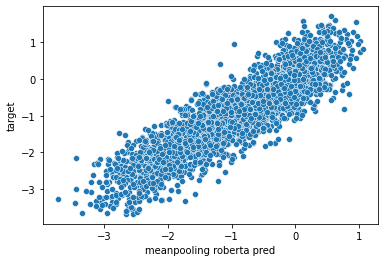

In [8]:
import seaborn as sns

sns.scatterplot(data=df_meanpooling, x='meanpooling roberta pred', y='target')

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

print('roberta base meanpooling RMSE is : ',np.sqrt(mean_squared_error(df_meanpooling['target'], df_meanpooling['meanpooling roberta pred'])))

roberta base meanpooling RMSE is :  0.4728365400916134


In [10]:
df_meanpooling.to_csv('meanpooling_roberta_stacking.csv',index=False)